In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares, curve_fit
import matplotlib.pyplot as plt
from util import BruxKori, Kinetic, Optimal, Tomira, Trigonometric
import math

In [2]:
data_pd = pd.read_csv('kkm_data.csv', delimiter=";")
pc = data_pd.columns[6:]

data = {}
for i in range(data_pd.shape[0]):
    data[int(data_pd["Лабораторный №"][i])] = {"kpr": float(data_pd["Кпр, мД"][i]),
                                               "kp": float(data_pd["Кп, %"][i]),
                                               "kv": np.array([float(i) for i in data_pd.loc[i][pc].tolist()])}
pc = np.array([float(i) for i in pc])

In [3]:
data[2]

{'kpr': 16.8,
 'kp': 35.8,
 'kv': array([100.  ,  96.28,  95.4 ,  94.5 ,  92.4 ,  88.74,  79.58,  71.16,
         65.42,  62.01])}

In [4]:
data_pd

,Месторождение,Скв.,Пласт,Лабораторный №,"Кпр, мД","Кп, %",0.001,0.016,0.027,0.047,0.081,0.139,0.238,0.406,0.7,1.2
0,Чудесное,1,VI-2,1,38.0,36.5,100,96.13,95.13,93.10,89.29,81.10,72.04,64.74,59.34,56.31
1,Чудесное,1,VI-2,2,16.8,35.8,100,96.28,95.40,94.50,92.40,88.74,79.58,71.16,65.42,62.01
2,Чудесное,1,VI-2,3,12.3,34.0,100,97.49,96.49,95.23,93.53,89.53,82.04,72.66,65.90,62.90
3,Чудесное,1,VI-2,4,51.0,36.8,100,94.43,93.40,91.48,85.23,75.49,66.59,60.40,56.40,54.30
4,Чудесное,1,VI-2,5,38.0,37.0,100,94.70,93.70,92.25,89.04,79.35,69.12,61.31,56.15,53.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Чудесное,1,XXI,78,98.0,31.7,100,96.55,93.37,87.40,75.65,64.50,57.32,51.51,47.64,45.06
76,Чудесное,1,XXI,79,61.0,33.4,100,97.05,95.18,91.91,81.45,70.48,62.03,55.69,51.52,48.96
77,Чудесное,1,XXI,80,78.0,32.3,100,97.93,96.06,91.31,79.90,68.87,59.62,52.97,48.50,45.94
78,Чудесное,1,XXI,81,20.0,30.9,100,98.24,97.04,95.84,92.84,86.33,78.82,72.87,67.93,64.93


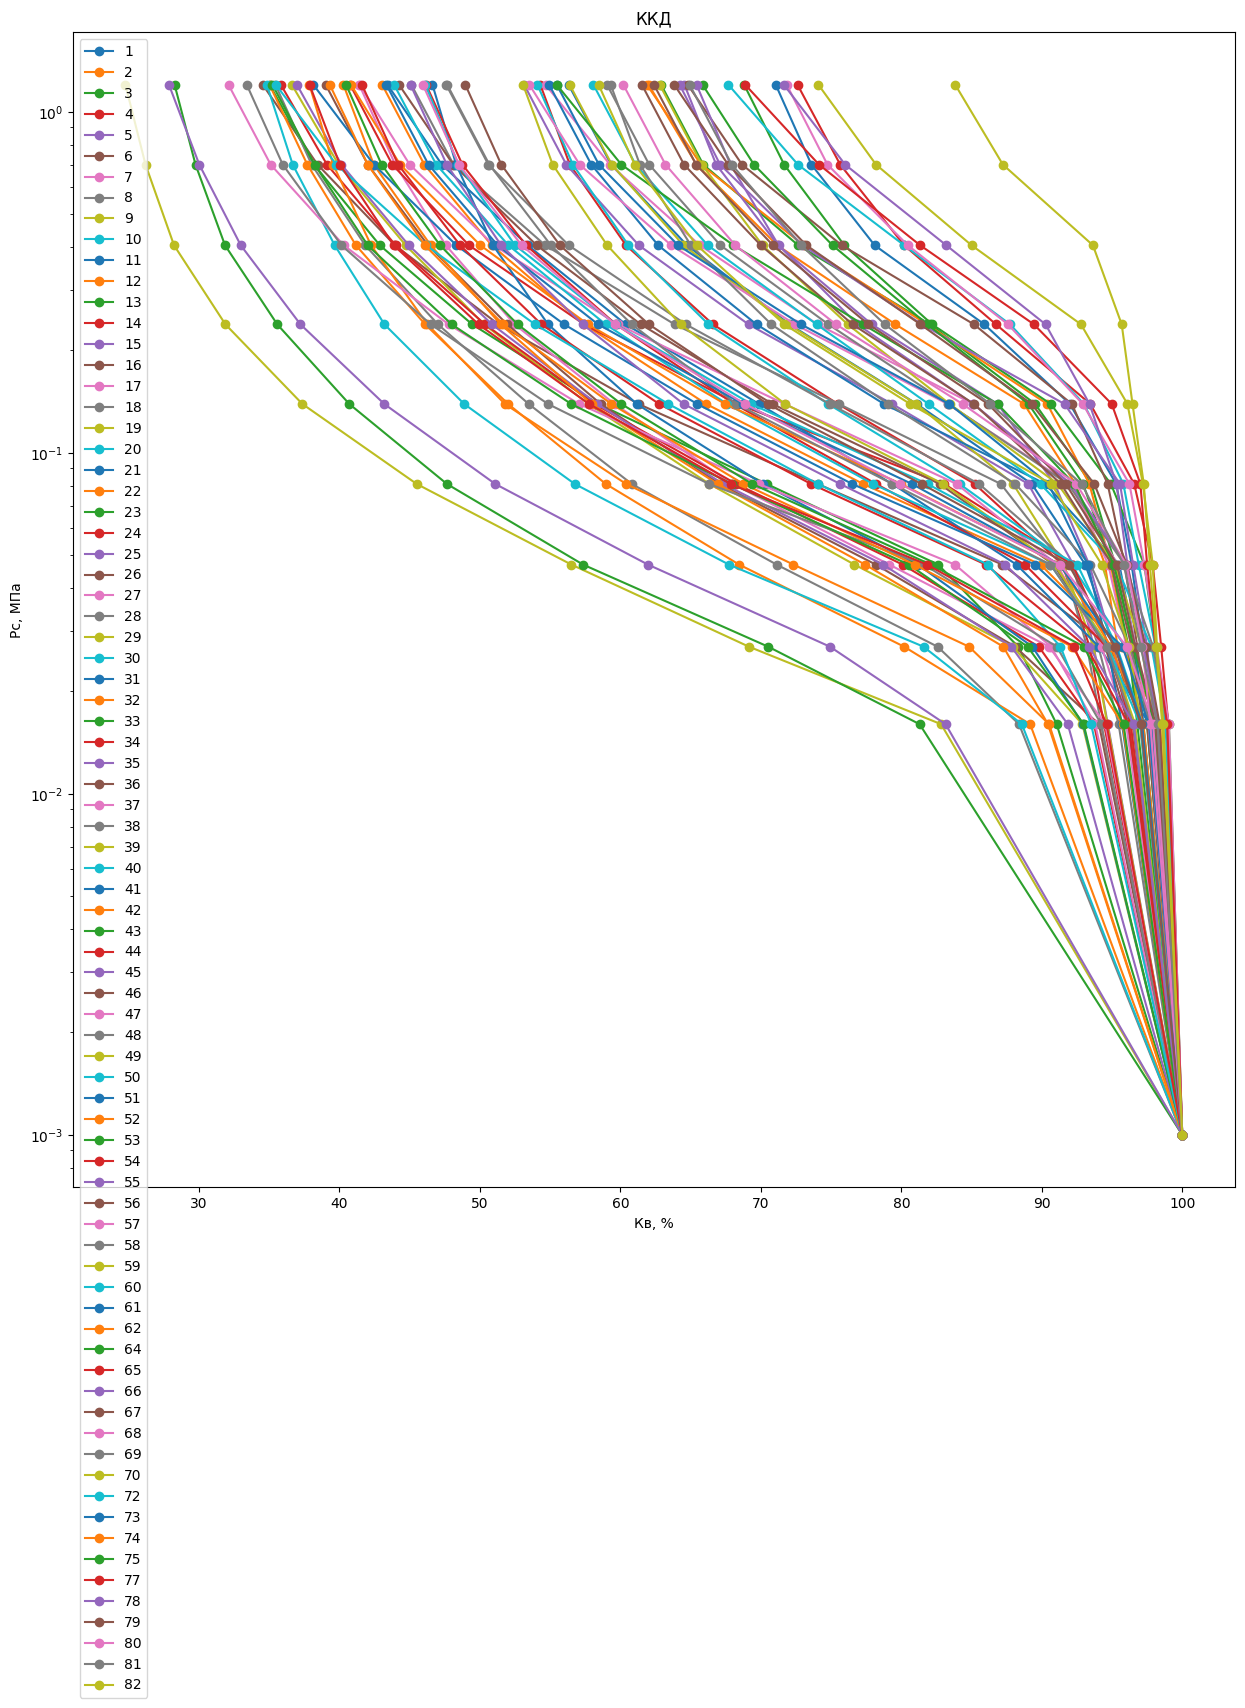

In [5]:
fig, ax = plt.subplots(figsize=(15,15))

for num in data.keys():
    ax.plot(data[num]["kv"], pc, marker="o", label = num)
ax.set_xlabel('Кв, %')
ax.set_ylabel('Pc, МПа')
ax.set_yscale('log')
ax.set_title("ККД")
ax.legend()


In [6]:
def fes_for_plot(data, model_name):
    params = []
    kpr = []

    for idx, num in enumerate(data.keys()):
        match model_name:
            case "BruxKori":   
                model = BruxKori(data[num]["kv"], pc)
            case "Kinetic":
                model = Kinetic(data[num]["kv"], pc)
            case "Optimal":
                model = Optimal(data[num]["kv"], pc)
            case "Tomira":
                model = Tomira(data[num]["kv"], pc)
            case "Trigonometric":
                model = Trigonometric(data[num]["kv"], pc)
            case _:
                return ValueError("This model is not implemented yet")
            
        params.append(np.append(model.fit(), model.kvo))
        kpr.append(data[num]["kpr"])
    
    return np.array(kpr), np.array(params).T

In [7]:
def power_law(x, a, b):
    return a * x ** b

def ln_law(x, a, b):
    return a * np.log(x) + b

def linear_law(x, a, b):
    return a * x + b

def plot_fes(kpr, params, titles, functions):
    fig, axs = plt.subplots(len(params[:, 0]), 1, figsize=(8, 6 * len(params[:, 0])))
    for i in range(len(params[:, 0])):
        axs[i].scatter(kpr, params[i], label="Образцы")

        # Fit the curve using curve_fit
        pred_params, _ = curve_fit(functions[i], kpr, params[i])
        a_fit, b_fit = pred_params  # Correctly unpack the fitted parameters

        # Generate the fitted curve
        x_fit = np.linspace(min(kpr), max(kpr), 100)  # Use more points for a smooth curve
        y_fit_curve = functions[i](x_fit, a_fit, b_fit)

        # Plot the fitted curve
        axs[i].plot(x_fit, y_fit_curve, '--g', label="Апроксимация")
        axs[i].set_title(titles[i])
        axs[i].legend()

        # Add the formula of the curve to the plot
        if functions[i] == power_law:
            formula_text = f"$y = {a_fit:.2f} \cdot x^{{{b_fit:.2f}}}$"
        elif functions[i] == ln_law:
            formula_text = f"$y = {a_fit:.2f} \cdot \ln(x) + {b_fit:.2f}$"
        elif functions[i] == linear_law:
            formula_text = f"$y = {a_fit:.2f} \cdot x + {b_fit:.2f}$"
        else:
            formula_text = "Формула неизвестна"

        axs[i].text(
            0.05, 0.95, formula_text,
            transform=axs[i].transAxes,
            fontsize=12,
            verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)
        )

    plt.tight_layout()
    plt.show()

<>:30: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\c'
<>:34: SyntaxWarning: invalid escape sequence '\c'
<>:30: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\c'
<>:34: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_65346/1785191282.py:30: SyntaxWarning: invalid escape sequence '\c'
  formula_text = f"$y = {a_fit:.2f} \cdot x^{{{b_fit:.2f}}}$"
/tmp/ipykernel_65346/1785191282.py:32: SyntaxWarning: invalid escape sequence '\c'
  formula_text = f"$y = {a_fit:.2f} \cdot \ln(x) + {b_fit:.2f}$"
/tmp/ipykernel_65346/1785191282.py:34: SyntaxWarning: invalid escape sequence '\c'
  formula_text = f"$y = {a_fit:.2f} \cdot x + {b_fit:.2f}$"


## Brux Kori

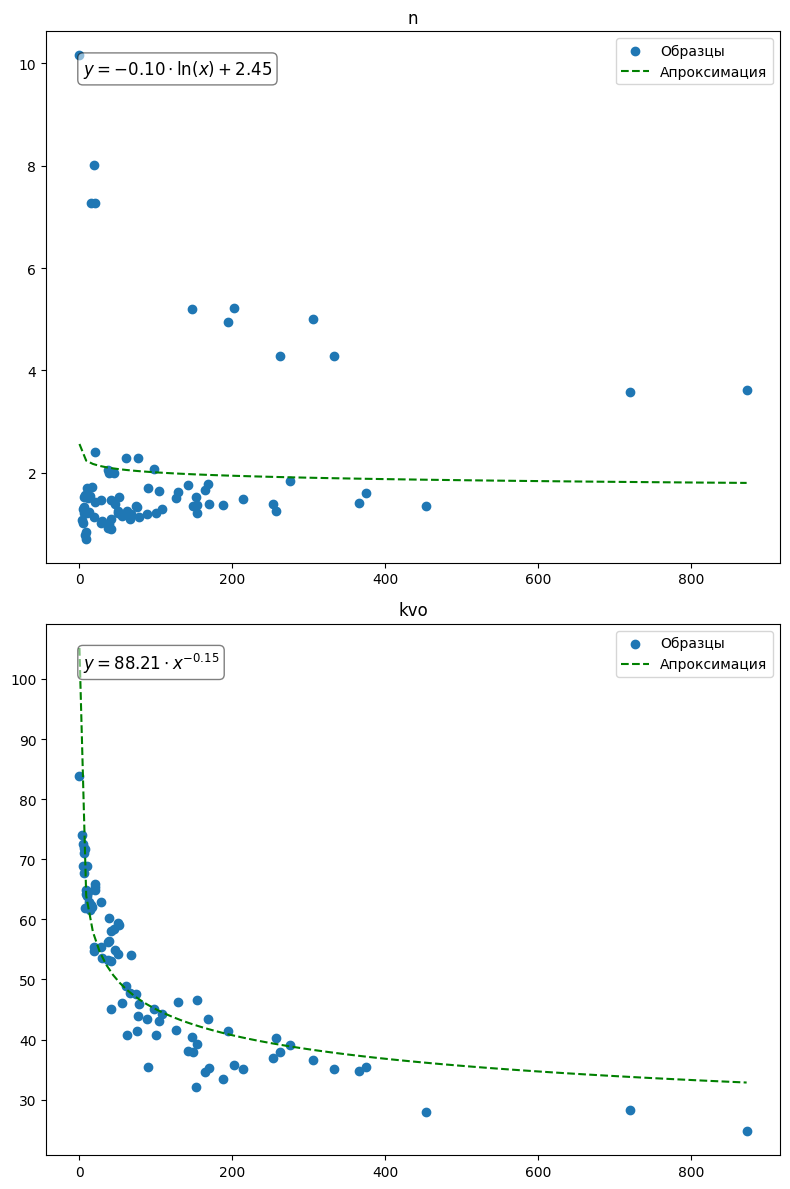

In [8]:
kpr, params = fes_for_plot(data, "BruxKori")
plot_fes(kpr, params, ["n", "kvo"], [ln_law, power_law])

## Kinetic

In [10]:
# kpr, params = fes_for_plot(data, "Kinetic")
# plot_fes(kpr, params, ["a", "b", "kvo"], [power_law, power_law, power_law])

## Optimal

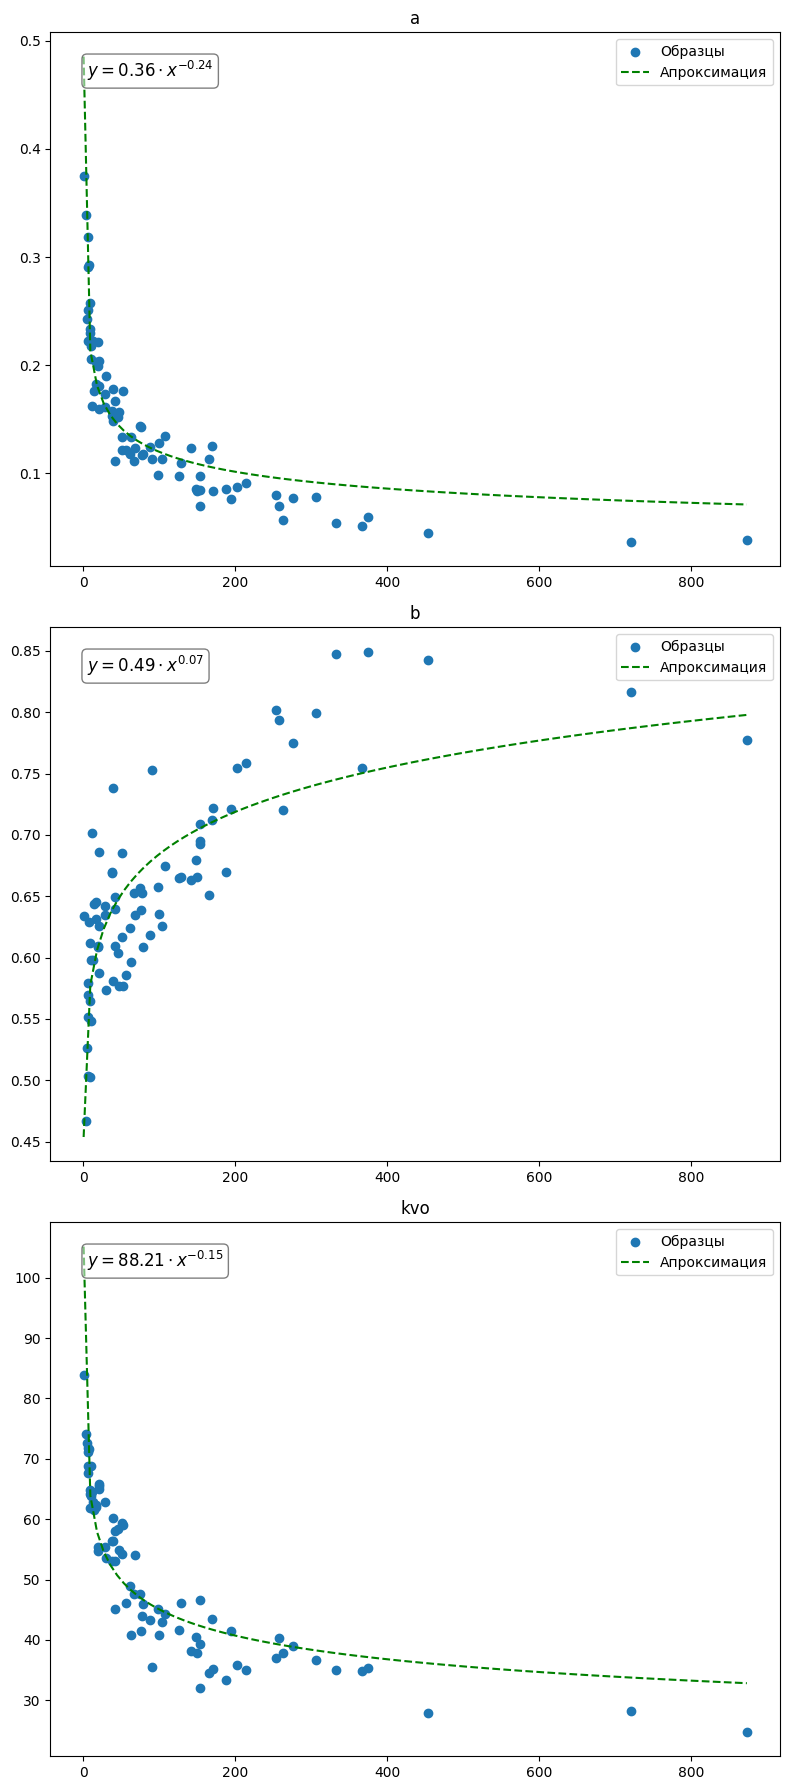

In [11]:
kpr, params = fes_for_plot(data, "Optimal")
plot_fes(kpr, params, ["a", "b", "kvo"], [power_law, power_law, power_law])

Оптимальная модель пока что является наилучшей  
## Модель Томира

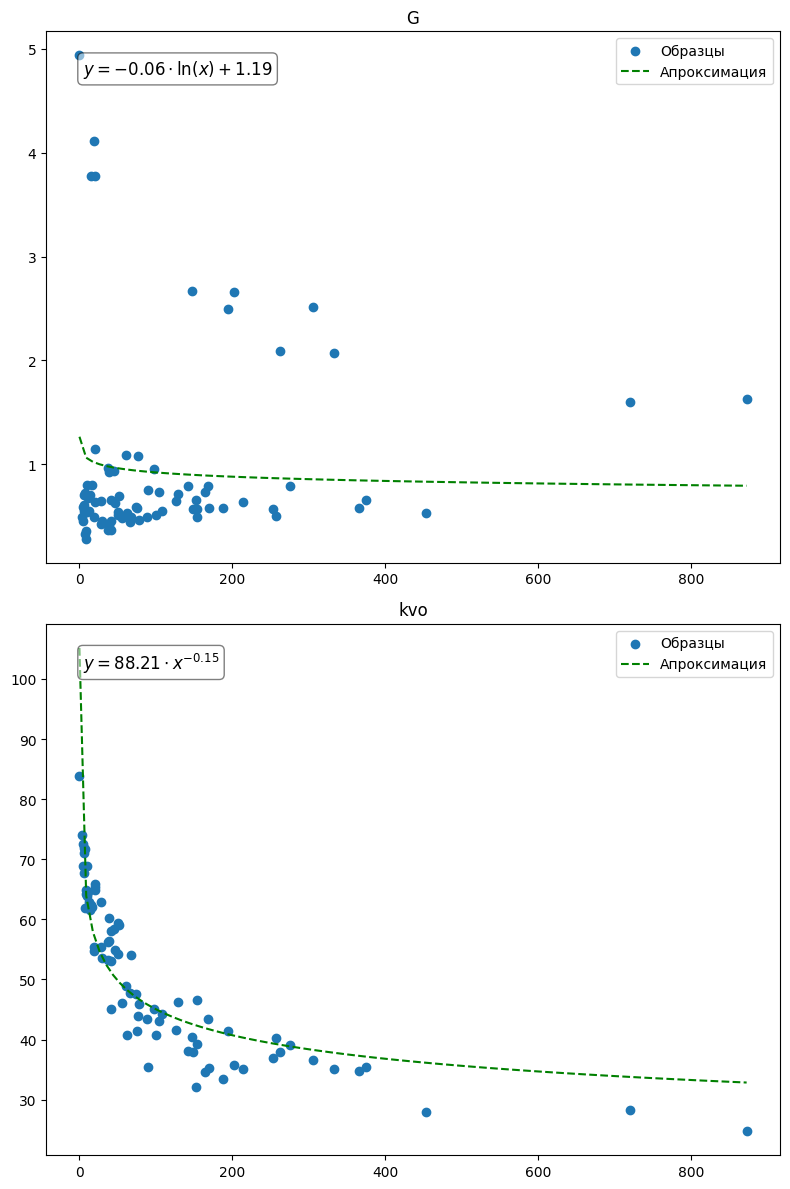

In [12]:
kpr, params = fes_for_plot(data, "Tomira")
plot_fes(kpr, params, ["G", "kvo"], [ln_law, power_law])

# Trigonometric

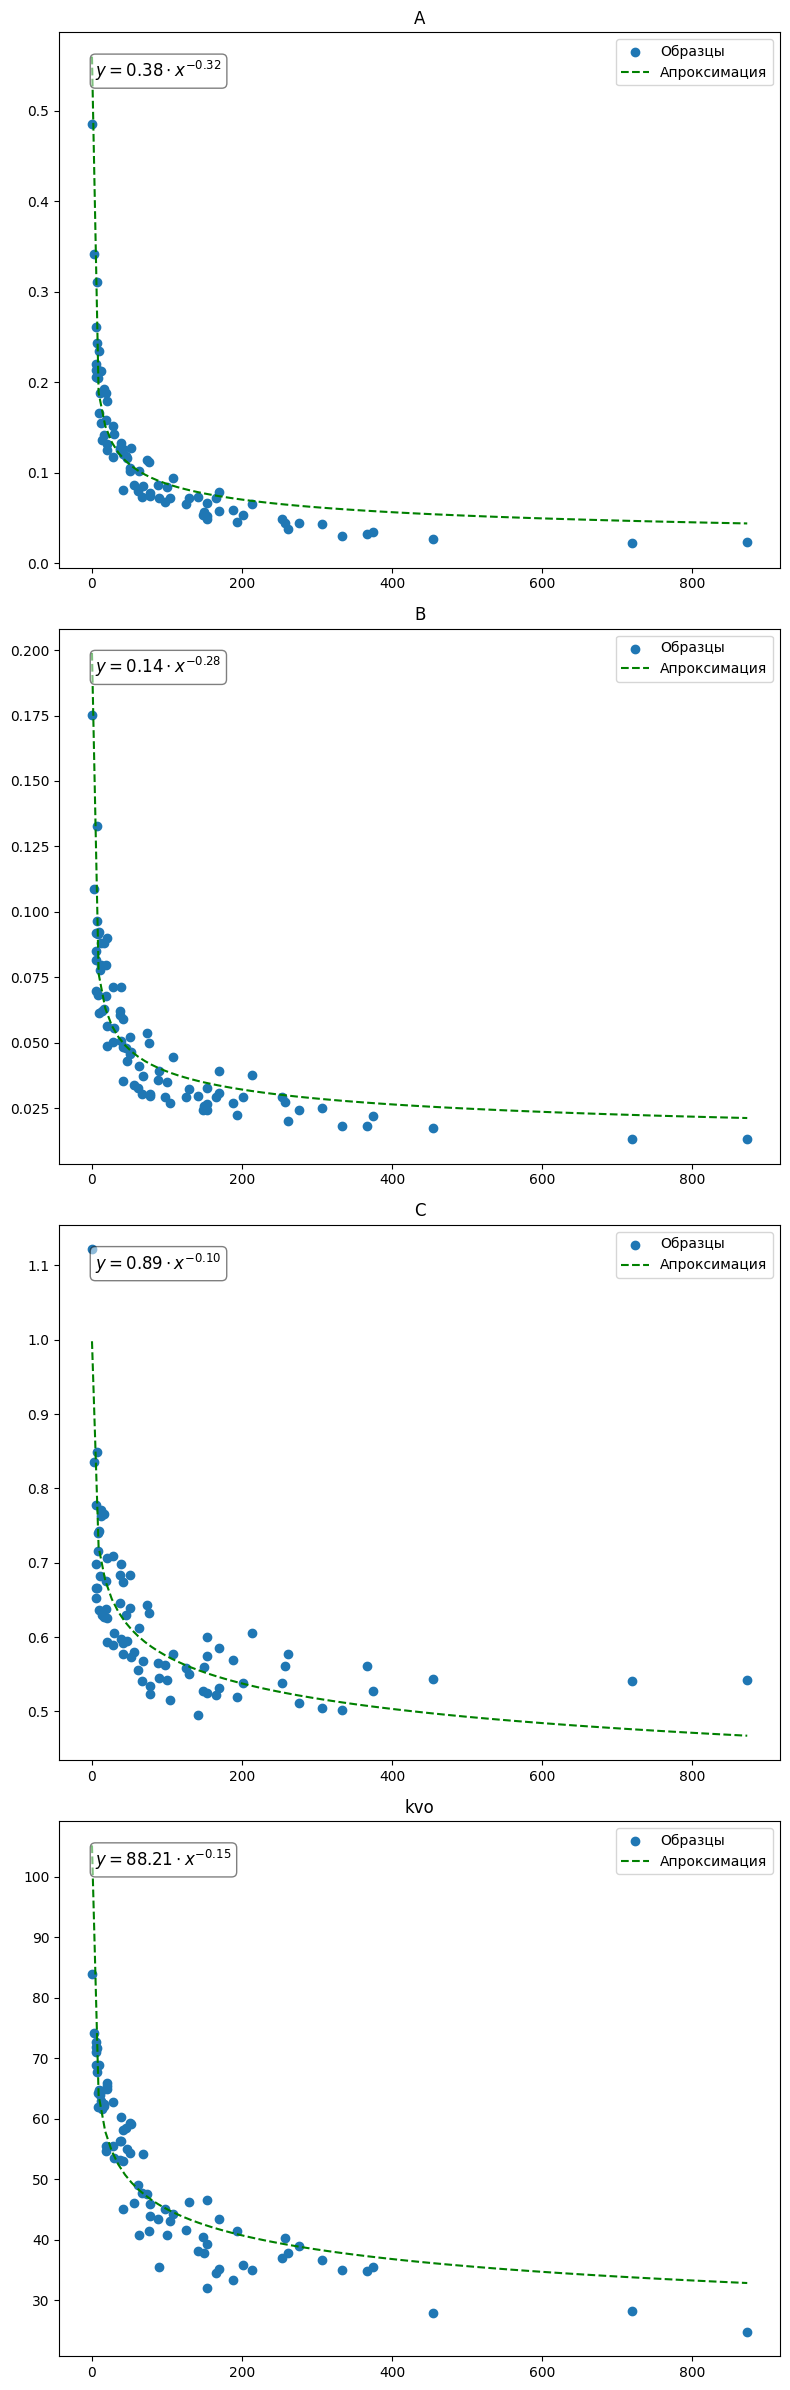

In [13]:
kpr, params = fes_for_plot(data, "Trigonometric")
plot_fes(kpr, params, ["A", "B", "C", "kvo"], [power_law, power_law, power_law, power_law])

# Средняя ошибка всех моделей

In [17]:
errors = {"brux": [], "optimal": [], "tomira": [], "trigonometric": []}
for idx, num in enumerate(data.keys()):
    model = BruxKori(data[num]["kv"], pc)
    params = ln_law(data[num]["kpr"], -0.10, 2.45)
    mask = np.full(pc.shape, True)
    errors["brux"].append(np.mean((model.kv - model.predict(params, mask = mask))/model.kv))

    model = Optimal(data[num]["kv"], pc)
    params = (power_law(data[num]["kpr"], 0.36, -0.24), power_law(data[num]["kpr"], 0.49, 0.07))
    errors["optimal"].append(np.mean((model.kv - model.predict(params))/model.kv))

    model = Tomira(data[num]["kv"], pc)
    mask = (model.pc >= model.pc_vh)
    params = ln_law(data[num]["kpr"], -0.06, 1.19)
    errors["tomira"].append(np.mean((model.kv[mask] - model.predict(params, mask = mask))/model.kv[mask]))

    model = Trigonometric(data[num]["kv"], pc)
    params = (power_law(data[num]["kpr"], 0.38, -0.32), power_law(data[num]["kpr"], 0.14, -0.28), power_law(data[num]["kpr"], 0.89, -0.10))
    errors["trigonometric"].append(np.mean((model.kv - model.predict(model.pc, A = params[0], B = params[1], C = params[2]))/model.kv))

print(f"brux: {np.abs(np.mean(errors["brux"]))*100}")
print(f"trigonometric: {np.abs(np.mean(errors["trigonometric"]))*100}")
print(f"optimal: {np.abs(np.mean(errors["optimal"]))*100}")
print(f"tomira: {np.abs(np.mean(errors["tomira"]))*100}")

brux: 28.942702326891666
trigonometric: 2.822347140898739
optimal: 1.9613447039397385
tomira: 8.752560854790726


In [ ]:
def plot_all_models(data, pc, model_name):
    """
    Function to iterate through all models, predict, and plot real and predicted curves.
    """
    num_models = len(data)
    num_cols = 4
    num_rows = math.ceil(num_models / num_cols)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    for idx, num in enumerate(data.keys()):
        mask = np.full(pc.shape, True)
        match model_name:
            case "BruxKori":   
                model = BruxKori(data[num]["kv"], pc)
            case "Kinetic":
                model = Kinetic(data[num]["kv"], pc)
                mask = (model.pc > model.pc_vh)
            case "Optimal":
                model = Optimal(data[num]["kv"], pc)
                params = params = (power_law(data[num]["kpr"], 0.36, -0.24), power_law(data[num]["kpr"], 0.49, 0.07))
            case "Tomira":
                model = Tomira(data[num]["kv"], pc)
                mask = (model.pc >= model.pc_vh)
            case "Trigonometric":
                model = Trigonometric(data[num]["kv"], pc)
        
        predicted = model.predict(params)
        real = model.kv
        
        ax = axes[idx]
        ax.plot(real, pc, marker="o", linestyle="-", label="Real")
        ax.plot(predicted, pc[mask], marker="o", linestyle="--", label="Predicted")
        
        ax.set_xlabel("Kv, %")
        ax.set_ylabel("Pc, МПа")
        ax.set_yscale("log")
        ax.set_title(f"Model {num}")
        ax.hlines(y=model.pc_vh, xmin=30, xmax=100, label="pc_vh", colors="r")
        ax.legend()
    
    # Hide unused subplots
    for ax in axes[num_models:]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()